In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set seaborn style for better visuals
sns.set(style="whitegrid")

In [ ]:
import os

base_dir = "../data_scraped/"

companies = ['samsung', 'apple', 'nintendo']

# Loop through each company and remove empty files
for company in companies:
    company_path = os.path.join(base_dir, company)
    
    for date_folder in os.listdir(company_path):
        date_path = os.path.join(company_path, date_folder)
        
        for csv_file in os.listdir(date_path):
            if csv_file.endswith(".csv"):
                file_path = os.path.join(date_path, csv_file)
                
                # Check if the file is empty
                if os.stat(file_path).st_size <= 2:
                    os.remove(file_path)
                    print(f"Removed empty file: {file_path}")

In [61]:
import pandas as pd
import os
from textblob import TextBlob
from tqdm import tqdm

base_dir = "../data_scraped/"
companies = ['samsung', 'apple', 'nintendo']
companies_username = ['SamsungMobile','theapplehub','NintendoAmerica']

tweet_records = []
user_records = {}

for company in companies:
    company_path = os.path.join(base_dir, company)

    for date_folder in tqdm(os.listdir(company_path), desc=f"Processing {company}"):
        date_path = os.path.join(company_path, date_folder)

        for csv_file in os.listdir(date_path):
            if not csv_file.endswith(".csv"):
                continue

            file_path = os.path.join(date_path, csv_file)
            try:
                df = pd.read_csv(file_path)
                if df.empty:
                    continue
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

            # Main tweet
            main = df.iloc[0]
            comments = df.iloc[1:]

            if main['username'] in companies_username:
                # Sentiments
                main_sentiment = TextBlob(str(main['text'])).sentiment.polarity
                comment_sentiments = comments['text'].dropna().apply(lambda x: TextBlob(str(x)).sentiment.polarity)
                avg_comment_sentiment = comment_sentiments.mean() if not comment_sentiments.empty else None

                # Tweet-level record
                tweet_records.append({
                        "tweet_id": csv_file.replace(".csv", ""),
                        "company": company,
                        "date": date_folder,
                        "username": main['username'],
                        "text": main['text'],
                        "replies": main['replies'],
                        "reposts": main['reposts'],
                        "likes": main['likes'],
                        "bookmarks": main['bookmarks'],
                        "views": main['views'],
                        "comment_count": len(comments),
                        "total_engagement": main['replies'] + main['likes'] + main['bookmarks'] + main['reposts'],
                        "main_sentiment": main_sentiment,
                        "avg_comment_sentiment": avg_comment_sentiment
                    })

            # User-level records (for clustering)
            for _, row in comments.iterrows():
                username = row['username']
                if pd.isna(username):
                    continue

                sentiment = TextBlob(str(row['text'])).sentiment.polarity
                if username not in user_records:
                    user_records[username] = {
                        "company": company,
                        "username": username,
                        "text": '',
                        "total_comments": 0,
                        "total_replies": 0,
                        "total_likes": 0,
                        "sentiments": []
                    }

                user_records[username]["text"] += str(row['text']) + " "
                user_records[username]["total_comments"] += 1
                user_records[username]["total_replies"] += row.get("replies", 0)
                user_records[username]["total_likes"] += row.get("likes", 0)
                user_records[username]["sentiments"].append(sentiment)

# Final DataFrames
df_tweets = pd.DataFrame(tweet_records)

user_data = []
for user, data in user_records.items():
    data["avg_sentiment"] = sum(data["sentiments"]) / len(data["sentiments"]) if data["sentiments"] else 0
    del data["sentiments"]
    user_data.append(data)

df_users = pd.DataFrame(user_data)

# Save to disk
#df_tweets.to_csv("cleaned_tweet_data.csv", index=False)
#df_users.to_csv("cleaned_user_data.csv", index=False)


Processing nintendo: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it]


In [62]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#\w+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

df_tweets['text'] = df_tweets['text'].apply(clean_text)
df_users['text'] = df_users['text'].apply(clean_text)

# Save cleaned data
#df_tweets.to_csv("cleaned_tweet_data.csv", index=False)
#df_users.to_csv("cleaned_user_data.csv", index=False)

In [63]:
df_tweets

,tweet_id,company,date,username,text,replies,reposts,likes,bookmarks,views,comment_count,total_engagement,main_sentiment,avg_comment_sentiment
0,1895323042286567440,samsung,2025-04-09,SamsungMobile,series offers enhanced convenience on the series,32,28,269,11,35685,50,340,0.100000,0.173268
1,1896062921077375472,samsung,2025-04-09,SamsungMobile,samsung marks a step forward with ai for every...,97,61,482,20,50063,79,660,0.136364,-0.014494
2,1897497432537358622,samsung,2025-04-09,SamsungMobile,world sleep day recovering from daylight savin...,34,20,174,8,36842,10,236,0.500000,0.033485
3,1900177650213412984,samsung,2025-04-09,SamsungMobile,vanessa hill a sleep scientist explores how te...,29,13,184,12,35346,59,238,0.250000,-0.015909
4,1907405936110776355,samsung,2025-04-09,SamsungMobile,samsung announced the new fe and galaxy tab s ...,31,32,275,6,35941,42,344,0.219913,0.106019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,1907821315546837470,nintendo,2025-04-14,NintendoAmerica,metroid prime beyond nintendo switch edition j...,379,1420,8961,613,1342873,352,11373,0.136364,0.094995
209,1907825530369462311,nintendo,2025-04-14,NintendoAmerica,heavy is the head that wears the crown day of ...,479,367,3054,193,418370,345,4093,-0.031818,-0.044465
210,1907847148089258055,nintendo,2025-04-14,NintendoAmerica,tied it up with a dunk a round of applause for...,265,181,1370,66,249213,207,1882,-0.054545,-0.015970
211,1907847290397597751,nintendo,2025-04-14,NintendoAmerica,when dk climbs them are they monkey bars or do...,354,582,5394,333,534145,210,6663,0.043182,0.020811


In [64]:
df_users

,company,username,text,total_comments,total_replies,total_likes,avg_sentiment
0,samsung,viklibeva,i want this i want this i want this i want this,4,0,0,0.000000
1,samsung,stufflistings,oneplus t pink oneplus t pink oneplus t pink o...,4,260,1928,-0.100000
2,samsung,nipunmarya,cant go wrong with the classics whats your pic...,4,300,988,-0.625000
3,samsung,StyleListings,single take i wonder why our teachers would do...,4,228,1144,-0.071429
4,samsung,CeliaKayo,can you guess which is the lucky charm can you...,4,164,432,0.333333
...,...,...,...,...,...,...,...
7959,nintendo,EagleFangMaster,drop the price,1,0,0,0.000000
7960,nintendo,lmonsqz,drop the price,1,0,0,0.000000
7961,nintendo,TellmeNinetails,they did it we have the aiming precision of a ...,1,0,0,0.000000
7962,nintendo,2edgyneko,looks like a new ps exclusive,1,0,0,0.136364


In [ ]:
import pandas as pd
import os
from textblob import TextBlob

base_dir = "../data_scraped/"
companies = ['samsung', 'apple', 'nintendo']
data = []

for company in companies:
    company_path = os.path.join(base_dir, company)
    
    for date_folder in os.listdir(company_path):
        date_path = os.path.join(company_path, date_folder)
        
        for csv_file in os.listdir(date_path):
            if csv_file.endswith(".csv"):
                file_path = os.path.join(date_path, csv_file)
                df = pd.read_csv(file_path)
                
                if df.empty: continue

                # Main tweet is first row
                main_tweet = df.iloc[0]
                comments = df.iloc[1:]

                # Sentiment analysis
                main_sentiment = TextBlob(str(main_tweet['text'])).sentiment.polarity
                comment_sentiments = comments['text'].dropna().apply(lambda x: TextBlob(str(x)).sentiment.polarity)
                
                avg_comment_sentiment = comment_sentiments.mean() if not comment_sentiments.empty else None
                
                data.append({
                    "tweet_id": csv_file.replace(".csv", ""),
                    "company": company,
                    "date": date_folder,
                    "username": main_tweet['username'],
                    "text": main_tweet['text'],
                    "replies": main_tweet['replies'],
                    "reposts": main_tweet['reposts'],
                    "likes": main_tweet['likes'],
                    "bookmarks": main_tweet['bookmarks'],
                    "views": main_tweet['views'],
                    "comment_count": len(comments),
                    "total_engagement": main_tweet['replies'] + main_tweet['likes'] + main_tweet['bookmarks'] + main_tweet['reposts'],
                    "main_sentiment": main_sentiment,
                    "avg_comment_sentiment": avg_comment_sentiment
                })

# Create final DataFrame
final_df = pd.DataFrame(data)


In [11]:
final_df

,tweet_id,company,date,username,text,replies,reposts,likes,bookmarks,views,comment_count,total_engagement,main_sentiment,avg_comment_sentiment
0,1885241802116239398,samsung,2025-04-09,Juanm06221,a S25 made of cheap plastic and weak glass and...,0,0,0,0,21,20,0,0.141667,-0.092619
1,1886751850436931953,samsung,2025-04-09,monocorporation,that's all Quantum-Safe in the future we do,0,0,0,0,18,23,0,0.000000,0.211462
2,1890329047713857741,samsung,2025-04-09,Taloooly_,WHERE IS THE ONE UI 7 UPDATE FFS?!?!?!\n\nWHY ...,0,0,10,0,306,61,10,0.000000,0.002678
3,1895003534867001421,samsung,2025-04-09,alibaba11167,Please start doings the samsung flagship phone...,0,0,0,0,20,26,0,0.191667,-0.013391
4,1895323042286567440,samsung,2025-04-09,SamsungMobile,#GalaxyBuds3 Series offers enhanced convenienc...,32,28,269,11,35685,50,340,0.100000,0.173268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,1907821315546837470,nintendo,2025-04-13,NintendoAmerica,Metroid Prime 4: Beyond Nintendo Switch 2 Edit...,379,1417,8962,614,1341811,43,11372,0.136364,0.014307
216,1907825530369462311,nintendo,2025-04-13,NintendoAmerica,Heavy is the head that wears the crown...\n\nD...,479,367,3052,195,417772,70,4093,-0.031818,0.009516
217,1907847148089258055,nintendo,2025-04-13,NintendoAmerica,Tied it up with a dunk! A round of applause fo...,265,180,1369,67,248671,215,1881,-0.054545,-0.031026
218,1907847290397597751,nintendo,2025-04-13,NintendoAmerica,When DK climbs them are they monkey bars or do...,354,580,5393,335,533426,229,6662,0.043182,0.000332


Text(0.5, 1.0, 'Total Engagement per Tweet by Company')

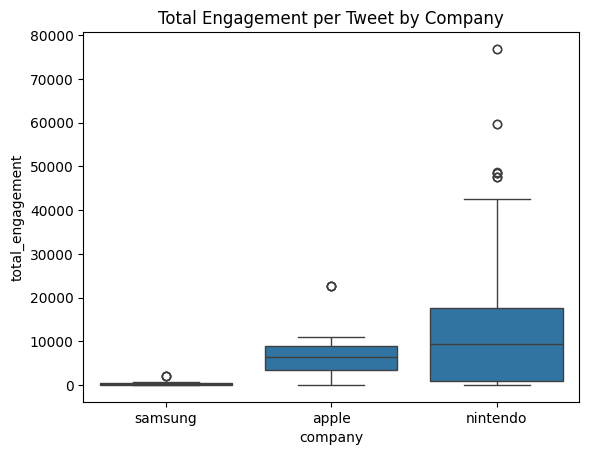

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=final_df, x="company", y="total_engagement")
plt.title("Total Engagement per Tweet by Company")


(array([20187. , 20187.5, 20188. , 20188.5, 20189. , 20189.5, 20190. ,
        20190.5, 20191. ]),
 [Text(20187.0, 0, '04-09 00'),
  Text(20187.5, 0, '04-09 12'),
  Text(20188.0, 0, '04-10 00'),
  Text(20188.5, 0, '04-10 12'),
  Text(20189.0, 0, '04-11 00'),
  Text(20189.5, 0, '04-11 12'),
  Text(20190.0, 0, '04-12 00'),
  Text(20190.5, 0, '04-12 12'),
  Text(20191.0, 0, '04-13 00')])

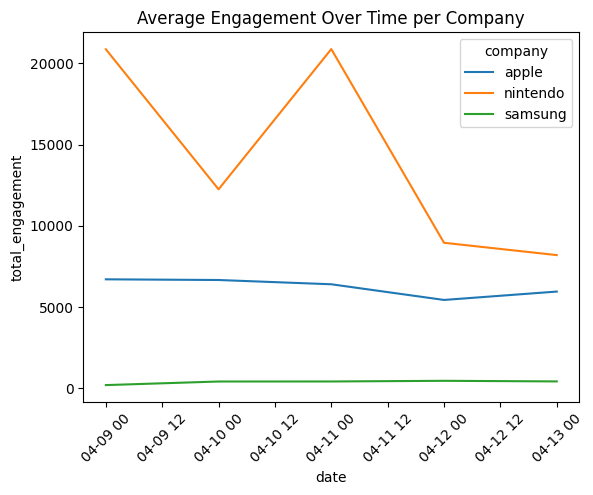

In [15]:
final_df['date'] = pd.to_datetime(final_df['date'])

df_grouped = final_df.groupby(['company', 'date'])[['likes', 'views', 'total_engagement']].mean().reset_index()

sns.lineplot(data=df_grouped, x='date', y='total_engagement', hue='company')
plt.title("Average Engagement Over Time per Company")
plt.xticks(rotation=45)

(array([20187. , 20187.5, 20188. , 20188.5, 20189. , 20189.5, 20190. ,
        20190.5, 20191. ]),
 [Text(20187.0, 0, '04-09 00'),
  Text(20187.5, 0, '04-09 12'),
  Text(20188.0, 0, '04-10 00'),
  Text(20188.5, 0, '04-10 12'),
  Text(20189.0, 0, '04-11 00'),
  Text(20189.5, 0, '04-11 12'),
  Text(20190.0, 0, '04-12 00'),
  Text(20190.5, 0, '04-12 12'),
  Text(20191.0, 0, '04-13 00')])

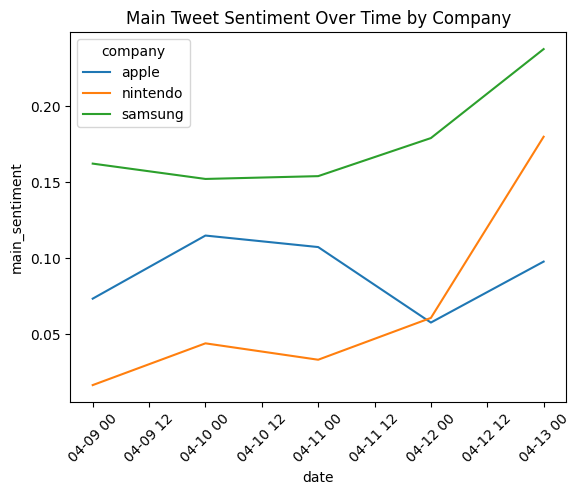

In [18]:
sentiment_by_date = final_df.groupby(['company', 'date'])[['main_sentiment', 'avg_comment_sentiment']].mean().reset_index()

sns.lineplot(data=sentiment_by_date, x='date', y='main_sentiment', hue='company')
plt.title("Main Tweet Sentiment Over Time by Company")
plt.xticks(rotation=45)

<Axes: >

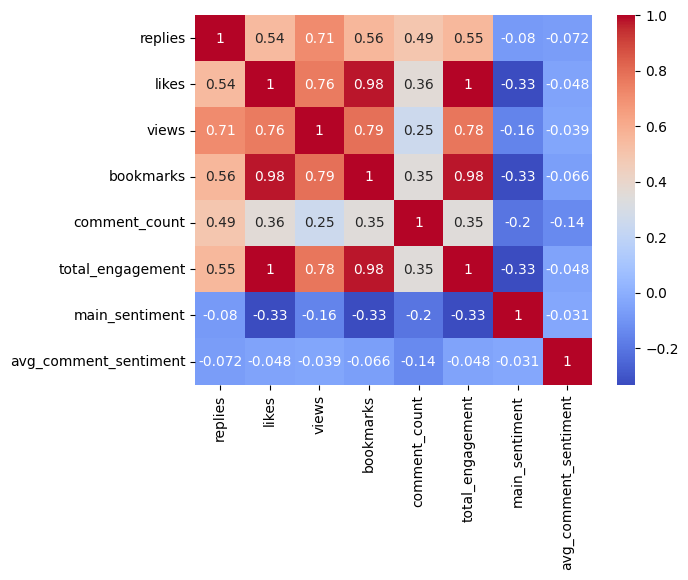

In [19]:
import seaborn as sns

numeric_cols = ['replies', 'likes', 'views', 'bookmarks', 'comment_count', 'total_engagement', 'main_sentiment', 'avg_comment_sentiment']
sns.heatmap(final_df[numeric_cols].corr(), annot=True, cmap="coolwarm")


In [20]:
top_engagement = final_df.sort_values(by="total_engagement", ascending=False).head(5)
most_negative = final_df.sort_values(by="main_sentiment").head(5)

Text(0.5, 1.0, 'Word Cloud of Main Tweets')

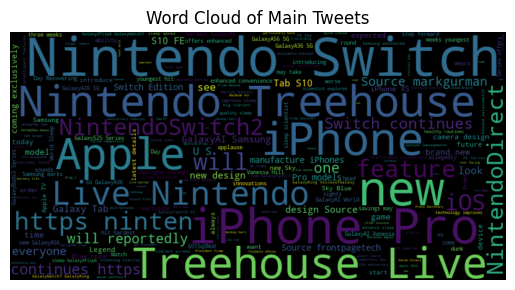

In [23]:
from wordcloud import WordCloud

text = " ".join(final_df['text'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Main Tweets")



In [43]:
import pandas as pd  # Required for pd.isna and DataFrame operations
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
import os
import sys

# Set the NLTK data path to the virtual environment
nltk_data_path = os.path.join(os.path.dirname(sys.executable), 'nltk_data')
nltk.data.path.append(nltk_data_path)

# Download necessary NLTK data to the specified path
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
# Load stopwords once
stop_words = set(stopwords.words('english'))

# Define preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    
    if pd.isna(text):
        return "img"  # Replace NaN with 'img'

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Example DataFrame (replace with your actual data)
# final_df = pd.read_csv('your_file.csv') or define it manually
# final_df['text'] = [...]

# Apply preprocessing to the 'text' column
final_df['processed_text'] = final_df['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to c:\Users\perso\Desktop\MLOPS\
[nltk_data]     github_projet\Twitter_Trend_Tracking_MLOps\myenv\Scrip
[nltk_data]     ts\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to c:\Users\perso\Desktop\ML
[nltk_data]     OPS\github_projet\Twitter_Trend_Tracking_MLOps\myenv\S
[nltk_data]     cripts\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to c:\Users\perso\Desktop\MLOP
[nltk_data]     S\github_projet\Twitter_Trend_Tracking_MLOps\myenv\Scr
[nltk_data]     ipts\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\perso/nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\share\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\lib\\nltk_data'
    - 'C:\\Users\\perso\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\Scripts\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\Scripts\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\Scripts\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\Scripts\\nltk_data'
    - 'c:\\Users\\perso\\Desktop\\MLOPS\\github_projet\\Twitter_Trend_Tracking_MLOps\\myenv\\Scripts\\nltk_data'
**********************************************************************


In [29]:
nan_rows = final_df[final_df.isna().any(axis=1)]
nan_rows

,tweet_id,company,date,username,text,replies,reposts,likes,bookmarks,views,comment_count,total_engagement,main_sentiment,avg_comment_sentiment
77,1907076621661856059,apple,2025-04-09,DaBossDon2014,NaN,0,0,8,0,624,404,8,0.0,0.097774
165,1907810797784354998,nintendo,2025-04-09,EiRi_1970,NaN,0,0,0,0,106,236,0,0.0,0.033648
213,1907810797784354998,nintendo,2025-04-13,JuansCarlosTM,NaN,0,0,13,0,306,127,13,0.0,0.080081


In [39]:
final_df.isna().sum()

tweet_id                 0
company                  0
date                     0
username                 0
text                     3
replies                  0
reposts                  0
likes                    0
bookmarks                0
views                    0
comment_count            0
total_engagement         0
main_sentiment           0
avg_comment_sentiment    0
dtype: int64